In [56]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import matplotlib.axes as ax
import datetime
import numpy as np
import time
import seaborn as sns
import os
from scipy.stats import zscore

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score, precision_score, recall_score, confusion_matrix
from sklearn.calibration import calibration_curve
from sklearn.neural_network import MLPClassifier
# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [57]:
import os
os.getcwd()

'C:\\Users\\dam20\\Downloads'

---------------------------------------------------------

In [58]:
df = pd.read_csv("loans_stage4.csv",index_col=0)

In [ ]:
crp = df.corr()
crs = df.corr("spearman")

In [ ]:
crp.loc[:,["loan_status", "realized_return","purpose", "West","Southwest", "South East", "North East", "Midwest"]].to_csv("pearson.csv")

In [ ]:
crs.loc[:,["loan_status", "realized_return","purpose", "West","Southwest", "South East", "North East", "Midwest"]].to_csv("spearman.csv")

In [59]:
# crp.to_csv("pearson.csv")
# crs.to_csv("spearman.csv")

We can see that the encoded columns "add_state" has close to 0 correlation both pearson and spearman with both "realized return" and "loan status", so we drop him, how ever we still want to check if purpose has any benefit to our model

In [60]:
df = df.drop(["West","Southwest", "South East", "North East", "Midwest"], axis = 1)

# Dealing with missing value

Checking missing value fractions

In [61]:
col_name = []
missing_value_prop = []
for i in df.columns: 
	# count number of rows with missing values
    n_miss = df[i].isnull().sum()
    if n_miss >0:
        col_name.append(i)
        missing_value_prop.append( n_miss / df.shape[0] * 100)
    
df_missing_val = pd.DataFrame({'Columns': col_name, 'missing_value_prop': missing_value_prop}) 

df_missing_val.sort_values("missing_value_prop")

,Columns,missing_value_prop
2,total_bal_il,0.0166
4,max_bal_bc,0.0166
5,all_util,0.0226
1,revol_util,0.0664
10,realized_return,0.1501
8,mths_since_recent_bc,1.0770
6,bc_open_to_buy,1.1445
9,percent_bc_gt_75,1.1532
7,bc_util,1.1951
3,il_util,13.9316


Looking at missing fraction we decided, for now, to drop instances of attributes with missing value of less then 1% since its neglegent.
For attributes with more less 1% missing values we will replace the NA with the median.
For attributes with more more than 1% missing values we will drop the instances

In [62]:
missing_to_drop = []
for i in range(df.shape[1]):
    n_miss = df.iloc[:,i].isnull().sum()
    perc = n_miss / df.shape[0] * 100
    if perc >1:
        missing_to_drop.append(df.columns[i]) # get columns names

        

In [63]:
for i in missing_to_drop:
    df =df[-df[i].isnull()]      

Fill NA of the rest of the columns with their median

In [64]:
df = df.fillna((df.median()))
#df_one_hot = df_one_hot.drop(["id"], axis = 1)

In [65]:
dd = df.copy()

# Base line grade model

In [66]:
base_line_grade = df.groupby(["grade"]).agg(["mean","median","std","min","max", "count"])["realized_return"]
base_line_grade["loans_frac"] = (df.groupby("grade").agg(["count"])["realized_return"])/len(df.index)

# Correlations

- We check attributes with co-linearity higher then 0.6, after reviwing them we drop one of the highly correlated attributes besides the ones we need suck as realozed return and loan status, **need to explain why 0.6**

In [67]:
correlated_features = set()
correlation_matrix = dd.corr()
dick = {}

In [68]:
for i in range(len(correlation_matrix .columns)): #Reviwe the correlation matrix
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.75:
            dick[correlation_matrix.columns[j]] = correlation_matrix.columns[i]
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [ ]:
# len(correlated_features)
#correlated_features


In [ ]:
#dick

In [69]:
corr_to_drop = ['avg_cur_bal',
 'bc_util',
 'fico_range_high',
 'grade',
 'num_bc_sats',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'percent_bc_gt_75',
 'tot_hi_cred_lim',
 'total_bal_ex_mort',
 'total_bc_limit',
 'total_il_high_credit_limit',
 'total_rev_hi_lim']

In [70]:
dd = dd.drop(corr_to_drop, axis = 1)

# Regression

In [71]:
X = dd.copy()
y = dd['realized_return']
y_status = dd['loan_status']
X_train, X_test, y_train, y_test, y_stat_train, y_stat_test = train_test_split(X, y, y_status, stratify = y_status,test_size=0.30)

In [72]:
y_test_relized_return = X_test["realized_return"] #save the real realized return of the test loans
y_test_loan_amount = X_test["loan_amnt"] #save the real loan amnt of the test loans

In [73]:
#and now drop them
X_train = X_train.drop(['loan_status', 'realized_return'], axis=1)
X_test = X_test.drop(['loan_status', 'realized_return'], axis=1)

In [74]:
GB = GradientBoostingRegressor()
GB.fit(X_train, y_train)

GradientBoostingRegressor()

In [75]:
y_pred_GB = GB.predict(X_test)

In [76]:
GB2 = GradientBoostingClassifier()
GB2.fit(X_train, y_stat_train)

GradientBoostingClassifier()

In [77]:
y_prob_GB2 = GB2.predict_proba(X_test)[:, 1]

In [78]:
prob_df_REG = pd.DataFrame({"prob" : y_pred_GB,"loan_amnt" : y_test_loan_amount, "realized_return": y_test_relized_return})
prob_df_CLA = pd.DataFrame({"prob" : y_prob_GB2,"loan_amnt" : y_test_loan_amount, "realized_return": y_test_relized_return})

In [79]:
prob_df_REG.sort_values('prob', ascending=False, inplace=True)
prob_df_CLA.sort_values('prob', ascending=True, inplace=True)

In [80]:
thresholds = np.arange(5000, 55001, 5000)
for thresh in thresholds:
    avg_reg = prob_df_REG.head(thresh).mean()['realized_return']
    sd_reg = prob_df_REG.head(thresh).std()['realized_return']
    avg_cla = prob_df_CLA.head(thresh).mean()['realized_return']
    sd_cla = prob_df_CLA.head(thresh).std()['realized_return']
    print('For %d top loans:' %thresh)
    print('REG --> %.3f average return andwith %.3f standard deviation' %(avg_reg, sd_reg))
    print('CLA --> %.3f average return andwith %.3f standard deviation' %(avg_cla, sd_cla))
    print('-------------------------------------------------------------\n')

For 5000 top loans:
REG --> 0.043 average return andwith 0.062 standard deviation
CLA --> 0.034 average return andwith 0.032 standard deviation
-------------------------------------------------------------

For 10000 top loans:
REG --> 0.040 average return andwith 0.059 standard deviation
CLA --> 0.034 average return andwith 0.040 standard deviation
-------------------------------------------------------------

For 15000 top loans:
REG --> 0.039 average return andwith 0.060 standard deviation
CLA --> 0.034 average return andwith 0.046 standard deviation
-------------------------------------------------------------

For 20000 top loans:
REG --> 0.037 average return andwith 0.061 standard deviation
CLA --> 0.034 average return andwith 0.051 standard deviation
-------------------------------------------------------------

For 25000 top loans:
REG --> 0.036 average return andwith 0.063 standard deviation
CLA --> 0.034 average return andwith 0.055 standard deviation
------------------------

# Oversampaling

In [81]:
# from imblearn.over_sampling import SMOTE

# X = dd
# y = dd['loan_status']
# X_train, X_test, y_train, y_test = train_test_split(dd, y, test_size=0.25, stratify=y)

# y_test_relized_return = X_test["realized_return"] #save the real realized return of the test loans
# y_test_loan_amount = X_test["loan_amnt"] #save the real loan amnt of the test loans

# #and now drop them
# X_train = X_train.drop(['loan_status', 'realized_return'], axis=1)
# X_test = X_test.drop(['loan_status', 'realized_return'], axis=1)

# smt = SMOTE()

# X_res, y_res = smt.fit_resample(X_train, y_train)

# y_train.value_counts()

# y_res.value_counts()

# Modeling

In [82]:
X = dd
y = dd['loan_status']
X_train, X_test, y_train, y_test = train_test_split(dd, y, test_size=0.3, stratify=y)

In [83]:
y_test_relized_return = X_test["realized_return"] #save the real realized return of the test loans
y_test_loan_amount = X_test["loan_amnt"] #save the real loan amnt of the test loans

In [84]:
#and now drop them
X_train = X_train.drop(['loan_status', 'realized_return'], axis=1)
X_test = X_test.drop(['loan_status', 'realized_return'], axis=1)

# Approch B - Classification model on loan status

In [85]:
def model_classification_results(y_pred, y_prob):
    print('Model recall: %.5f' % recall_score(y_test, y_pred))
    print('Model precision_score: %.5f' % precision_score(y_test, y_pred))
    print('Model roc_auc_score: %.5f' % roc_auc_score(y_test, y_pred))
    print('Model accuracy_score: %.5f' % accuracy_score(y_test,y_pred))

    confusion_matrix_pred = pd.DataFrame(confusion_matrix(y_test, y_pred),
                                            columns=pd.MultiIndex.from_product([['Prediction'], ['Fully Paid', 'Charged Off']]),
                                            index=pd.MultiIndex.from_product([['Actual'], ['Fully Paid', 'Charged Off']]))
    print("Model confusion matrix\n")
    print(confusion_matrix_pred)
    test = pd.DataFrame({"prob" : y_prob, "loan_status" : y_test})
    predicted_FP_RR = np.mean(y_test_relized_return[y_pred == 0])


    print("\nReal mean return of loans classified as Fully paid %.4f" % predicted_FP_RR) #calculate the reale mean realized 
    #return of loans classified as Fully paid

In [86]:
def res(y_prob): #function to check and plot the realized return for each threshold
    meanR = np.arange(0)
    sdmeanR = np.arange(0)
    investment = np.arange(0)
    thresholds = np.arange(0.04, 1.0, 0.02)
    for i in thresholds:
        y_pred = (y_prob >= i).astype('int')
        meanR = np.append(meanR, np.mean(y_test_relized_return[y_pred == 0]))
        sdmeanR = np.append(sdmeanR, np.std(y_test_relized_return[y_pred == 0]))
        investment = np.append(investment, np.sum(y_test_loan_amount[y_pred == 0]))
    return pd.DataFrame({"c_thresholds" : thresholds,"meanR" : meanR, "sdmeanR" : sdmeanR, "investment_frac" : investment/np.sum(y_test_loan_amount),
                         "investment" : investment,
                   "lower_bound" : meanR-sdmeanR, "upper_bound" : meanR+sdmeanR
                  })


In [87]:
def retrun_invest(df):
    sns.lineplot("c_thresholds", "meanR", data = df)
    plt.ylabel('Mean realized return')
    plt.xlabel('Threshold to predict as default')
    plt.show()

In [88]:
def plot_roc_propbs(y_prob): #plot model roc curve and histogram of probabilties
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    plt.figure(figsize = (13, 4.5))
    plt.subplot(1, 2, 1)

    plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_prob))
    plt.plot(fpr, tpr, 'b')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0,1]); plt.ylim([0,1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')


    plt.subplot(1, 2, 2)
    plt.hist(y_prob, range=(0, 1), bins=10, histtype="step", lw=2)
    plt.xlim([0,1]); plt.ylim([0,20000])
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Count')

In [89]:
def threshhold_dist(df, model):
    sns.violinplot(x = "prob", data = df[df.loan_status == 1])
    plt.title("%s probabilities distrabution defualt" % model)
    plt.xlabel('Model defualt probabilities')
    plt.show()
    sns.violinplot(x = "prob", data = df[df.loan_status == 0])
    plt.title("%s probabilities distrabution fully paid" % model)
    plt.xlabel('Model defualt probabilities')
    plt.show()
    sns.histplot(x = "prob", data = df, hue = "loan_status", bins = 50)
    plt.title("%s probabilities distrabution defualt" % model)
    plt.xlabel('Model defualt probabilities')
    plt.show()

# Random forest

In [90]:
# logistic regression
RF = RandomForestClassifier()
RF.fit(X_train, y_train)

RandomForestClassifier()

In [91]:
threshold = 0.3 #set threshold for classification decidion
y_prob_RF = RF.predict_proba(X_test)[:, 1] # get probability
y_pred_RF = (y_prob_RF >= threshold).astype('int')

In [92]:
res_RF = res(y_prob_RF)

In [93]:
fpr_RF, tpr_RF, thresholds = roc_curve(y_test, y_prob_RF)

In [94]:
prob_df_RF = pd.DataFrame({"prob" : y_prob_RF,"loan_status" : y_test})

# Gradient boosting

In [95]:
# logistic regression
GB = GradientBoostingClassifier()
GB.fit(X_train, y_train)

GradientBoostingClassifier()

In [96]:
threshold = 0.3 #set threshold for classification decidion
y_prob_GB = GB.predict_proba(X_test)[:, 1] # get probability
y_pred_GB = (y_prob_GB >= threshold).astype('int')


In [97]:
res_GB = res(y_prob_GB)

In [98]:
fpr_GB, tpr_GB, thresholds = roc_curve(y_test, y_prob_GB)

In [99]:
prob_df_GB = pd.DataFrame({"prob" : y_prob_GB,"loan_status" : y_test})

# Logistic regression

In [100]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [101]:
# logistic regression
LG = LogisticRegression(max_iter = 500)
LG.fit(X_train, y_train)
y_pred_LG = LG.predict(X_test)
y_prob_LG = LG.predict_proba(X_test)[:, 1]

In [102]:
threshold = 0.3 #set threshold for classification decidion
y_pred_LG = (y_prob_LG >= threshold).astype('int')

In [103]:
res_LG = res(y_prob_LG)

In [104]:
fpr_LG, tpr_LG, thresholds = roc_curve(y_test, y_prob_LG)

In [105]:
prob_df_LG = pd.DataFrame({"prob" : y_prob_LG,"loan_status" : y_test})

In [106]:
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

# Model comperassion

In [107]:
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
matplotlib.rcParams.update({'font.size': 15})

 - ROC

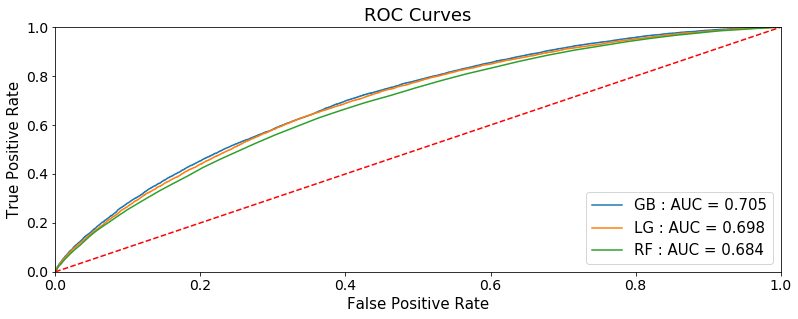

In [108]:
plt.figure(figsize = (13, 4.5))

plt.title("ROC Curves")
plt.plot(fpr_GB, tpr_GB, label = "GB : AUC = %.3f" % roc_auc_score(y_test, y_prob_GB))
plt.plot(fpr_LG, tpr_LG, label = "LG : AUC = %.3f" % roc_auc_score(y_test, y_prob_LG))
plt.plot(fpr_RF, tpr_RF, label = "RF : AUC = %.3f" % roc_auc_score(y_test, y_prob_RF))
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1]); plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = "lower right")
plt.show()

- thresholds VS mean Return

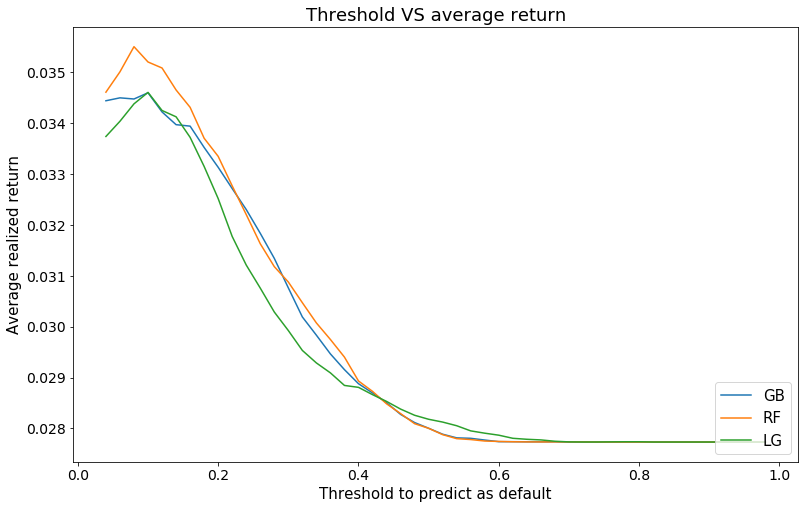

In [109]:
#thresholds VS mean Return
plt.figure(figsize = (13, 8))
plt.title("Threshold VS average return")
plt.plot("c_thresholds", "meanR", data = res_GB, label = "GB")
plt.plot("c_thresholds", "meanR", data = res_RF, label = "RF")
plt.plot("c_thresholds", "meanR", data = res_LG, label = "LG")
plt.ylabel('Average realized return')
plt.xlabel('Threshold to predict as default')
plt.legend(loc = "lower right")
plt.show()

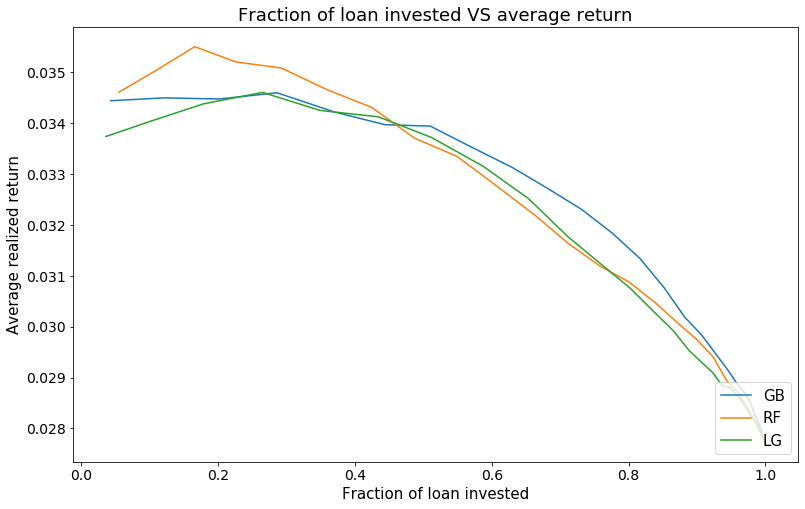

In [110]:
# investment_frac thresholds VS mean Return
plt.figure(figsize = (13, 8))
plt.title("Fraction of loan invested VS average return")
plt.plot("investment_frac", "meanR", data = res_GB, label = "GB")
plt.plot("investment_frac", "meanR", data = res_RF, label = "RF")
plt.plot("investment_frac", "meanR", data = res_LG, label = "LG")
plt.ylabel('Average realized return')
plt.xlabel('Fraction of loan invested')
plt.legend(loc = "lower right")
plt.show()

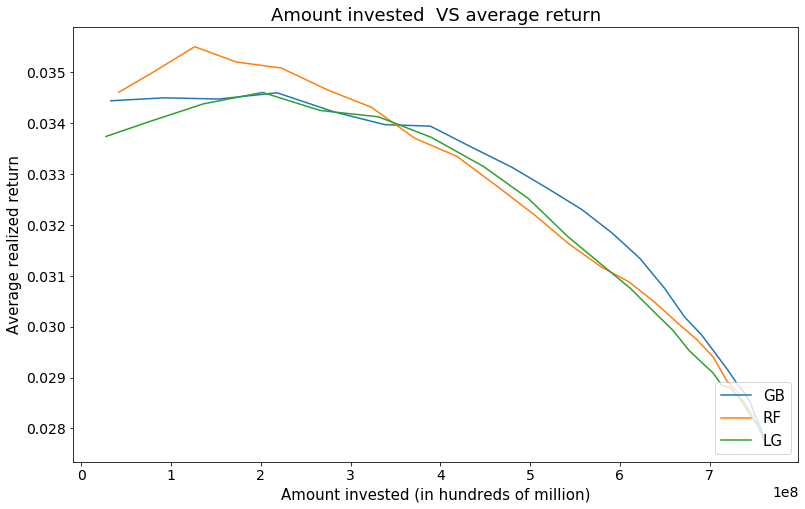

In [111]:
# investment_frac thresholds VS mean Return
plt.figure(figsize = (13, 8))
plt.title("Amount invested  VS average return")
plt.plot("investment", "meanR", data = res_GB, label = "GB")
plt.plot("investment", "meanR", data = res_RF, label = "RF")
plt.plot("investment", "meanR", data = res_LG, label = "LG")
plt.ylabel('Average realized return')
plt.xlabel('Amount invested (in hundreds of million)')
plt.legend(loc = "lower right")
plt.show()

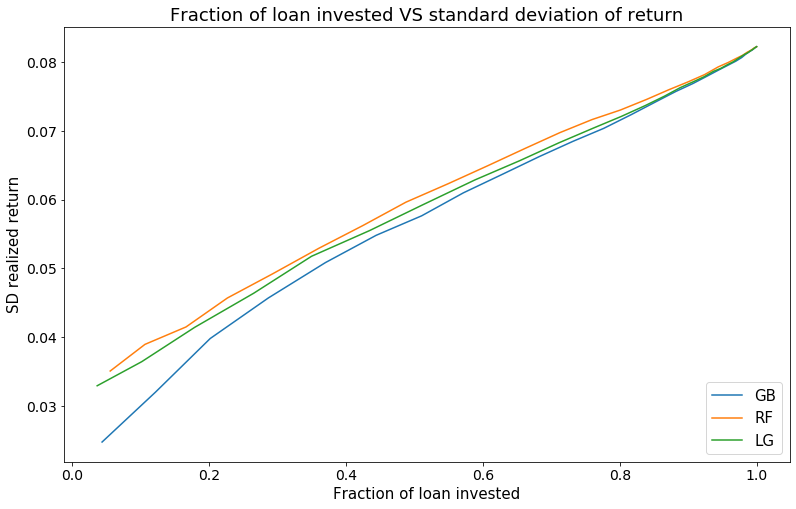

In [112]:
# investment_frac SD VS SD Return
plt.figure(figsize = (13, 8))
plt.title("Fraction of loan invested VS standard deviation of return")
plt.plot("investment_frac", "sdmeanR", data = res_GB, label = "GB")
plt.plot("investment_frac", "sdmeanR", data = res_RF, label = "RF")
plt.plot("investment_frac", "sdmeanR", data = res_LG, label = "LG")
plt.ylabel('SD realized return')
plt.xlabel('Fraction of loan invested')
plt.legend(loc = "lower right")
plt.show()

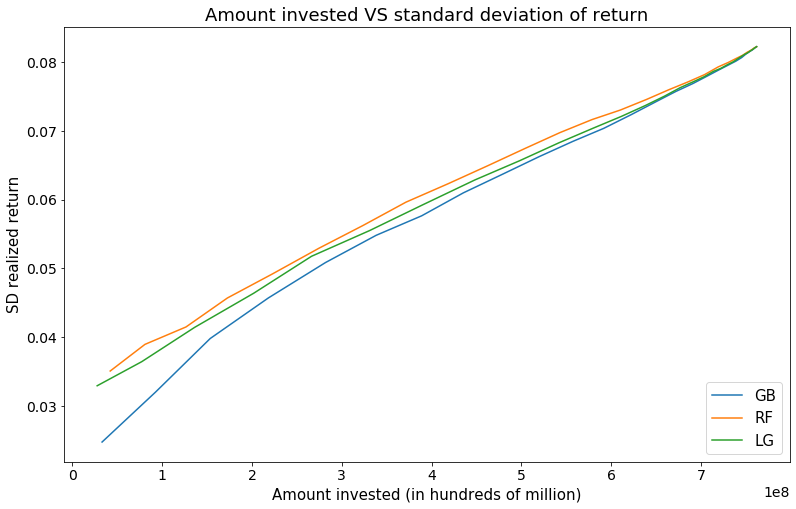

In [113]:
plt.figure(figsize = (13, 8))
plt.title("Amount invested VS standard deviation of return")
plt.plot("investment", "sdmeanR", data = res_GB, label = "GB")
plt.plot("investment", "sdmeanR", data = res_RF, label = "RF")
plt.plot("investment", "sdmeanR", data = res_LG, label = "LG")
plt.ylabel('SD realized return')
plt.xlabel('Amount invested (in hundreds of million)')
plt.legend(loc = "lower right")
plt.show()

# Models probabilities distrabution

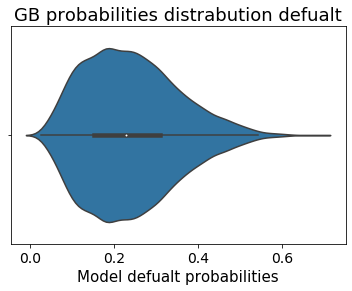

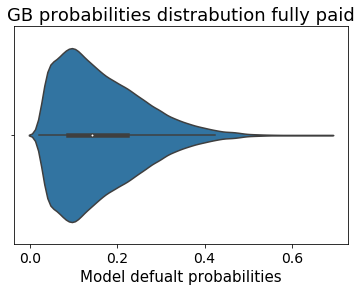

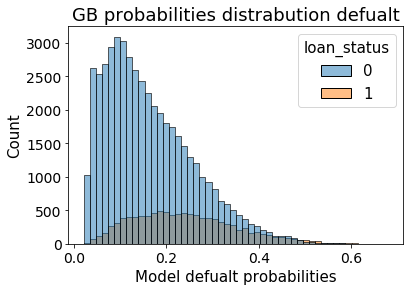

In [114]:
threshhold_dist(prob_df_GB, "GB")

In [115]:
base_line_grade

,mean,median,std,min,max,count,loans_frac
grade,,,,,,,
1,-0.0020,0.0400,0.1536,-0.3197,0.1942,333,0.0017
2,0.0046,0.0514,0.1440,-0.3199,0.2010,1434,0.0074
3,0.0162,0.0666,0.1296,-0.3210,0.1813,6352,0.0327
4,0.0194,0.0679,0.1130,-0.3212,0.1575,22288,0.1148
5,0.0257,0.0658,0.0925,-0.3235,0.1294,54659,0.2815
6,0.0305,0.0558,0.0708,-0.3303,0.1108,67470,0.3475
7,0.0323,0.0409,0.0451,-0.3227,0.0957,41611,0.2143


In [119]:
res_GB

,c_thresholds,meanR,sdmeanR,investment_frac,investment,lower_bound,upper_bound
0,0.0400,0.0344,0.0248,0.0433,32985125,0.0097,0.0592
1,0.0600,0.0345,0.0320,0.1213,92449500,0.0025,0.0665
2,0.0800,0.0345,0.0398,0.2014,153452875,-0.0053,0.0743
3,0.1000,0.0346,0.0457,0.2863,218138900,-0.0111,0.0803
4,0.1200,0.0342,0.0509,0.3698,281818575,-0.0166,0.0851
5,0.1400,0.0340,0.0548,0.4439,338236475,-0.0208,0.0888
6,0.1600,0.0339,0.0576,0.5104,388893775,-0.0237,0.0916
7,0.1800,0.0335,0.0610,0.5714,435411950,-0.0275,0.0945
8,0.2000,0.0331,0.0637,0.6296,479749150,-0.0306,0.0969
9,0.2200,0.0327,0.0662,0.6821,519801475,-0.0335,0.0990
